# Pokemon Card Database Visualization

This notebook demonstrates how to connect to the Pokemon TCG database, retrieve card data, and visualize sample cards.

## Setup
- Connects to the Pokemon TCG API via our database module
- Loads cards from cache or fetches from API
- Displays card images and metadata


In [38]:
import sys
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Add parent directories to path
notebook_dir = Path.cwd()
project_root = notebook_dir.parent.parent
sys.path.insert(0, str(project_root))

# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import requests
from io import BytesIO
from typing import List, Optional
import json

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print(f"Project root: {project_root}")
print(f"Python version: {sys.version}")
print("Setup complete!")


Project root: /home/khalil/pkmn_card_detection
Python version: 3.10.12 (main, May 27 2025, 17:12:29) [GCC 11.4.0]
Setup complete!


In [25]:
# Import our database module
from database import PokemonTCGClient, CacheManager
from core.logging_config import setup_logger

# Set up logging
logger = setup_logger("notebook_01")
logger.info("Initializing Pokemon TCG client and cache manager...")


2025-08-06 20:24:52 - notebook_01 - INFO - 4143987526.py:7 - Initializing Pokemon TCG client and cache manager...


In [26]:
# Initialize API client and cache manager
client = PokemonTCGClient()
cache = CacheManager()

# Check cache statistics
cache_stats = cache.get_cache_stats()
print("Cache Statistics:")
print(f"  Total entries: {cache_stats.get('total_entries', 0)}")
print(f"  Total size: {cache_stats.get('total_size_mb', 0):.2f} MB")
print(f"  Valid entries: {cache_stats.get('valid_entries', 0)}")
print(f"  Expired entries: {cache_stats.get('expired_entries', 0)}")


2025-08-06 20:24:52 - database.api_client - INFO - api_client.py:49 - Pokemon TCG API client initialized
2025-08-06 20:24:52 - database.cache_manager - INFO - cache_manager.py:42 - Cache manager initialized with directory: cache
Cache Statistics:
  Total entries: 1
  Total size: 0.14 MB
  Valid entries: 1
  Expired entries: 0


## Load Card Data

First, we'll try to load cards from cache. If no cache exists, we'll fetch a sample from the API.


In [27]:
# Try to load cards from cache
cards = cache.load_cards()
if cards is None:
    cards = []
n_cards_to_fetch = 100

if cards is None or len(cards) < n_cards_to_fetch:
    print("No cached cards found. Fetching sample cards from API...")
    # Fetch a sample of cards (limit to 100 for demo)
    search_result = client.search_cards(page=1, page_size=(n_cards_to_fetch - len(cards)))
    cards = search_result.data
    
    if cards:
        print(f"Fetched {len(cards)} cards from API")
        # Cache them for future use
        cache.save_cards(cards, ttl_days=7)
        print("Cards cached successfully")
    else:
        print("Failed to fetch cards from API")
else:
    print(f"Loaded {len(cards)} cards from cache")

# Display basic statistics
if cards:
    print(f"\nTotal cards loaded: {len(cards)}")
    
    # Get unique sets
    unique_sets = set(
        card.set.id for card in cards
    )
    print(f"Unique sets: {len(unique_sets)}")
    
    # Get card types distribution
    types_count = {}
    for card in cards:
        for card_type in card.types:
            types_count[card_type] = types_count.get(card_type, 0) + 1
    
    if types_count:
        print("\nCard types distribution:")
        for card_type, count in sorted(types_count.items(), key=lambda x: x[1], reverse=True)[:5]:
            print(f"  {card_type}: {count}")


2025-08-06 20:24:52 - database.cache_manager - INFO - cache_manager.py:172 - Loaded 100 cards from cache
Loaded 100 cards from cache

Total cards loaded: 100
Unique sets: 44

Card types distribution:
  Grass: 43
  Fire: 11
  Metal: 9
  Colorless: 9
  Psychic: 8


## Visualization Functions

Helper functions to display card images and information.


In [28]:
def fetch_image(url: str) -> Optional[Image.Image]:
    """Fetch an image from URL."""
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        return Image.open(BytesIO(response.content))
    except Exception as e:
        logger.error(f"Failed to fetch image from {url}: {e}")
        return None


def display_card(card, show_details: bool = True):
    """Display a single card with its image and details."""
    fig, axes = plt.subplots(1, 2 if show_details else 1, figsize=(12 if show_details else 6, 6))
    
    if not show_details:
        axes = [axes]
    
    # Display card image
    if card.image_url:
        img = fetch_image(card.image_url)
        if img:
            axes[0].imshow(img)
            axes[0].axis('off')
            axes[0].set_title(card.full_name, fontsize=14, fontweight='bold')
        else:
            axes[0].text(0.5, 0.5, 'Image not available', ha='center', va='center')
            axes[0].set_title(card.full_name, fontsize=14, fontweight='bold')
            axes[0].axis('off')
    else:
        axes[0].text(0.5, 0.5, 'No image URL', ha='center', va='center')
        axes[0].set_title(card.full_name, fontsize=14, fontweight='bold')
        axes[0].axis('off')
    
    # Display card details
    if show_details:
        details = []
        details.append(f"Name: {card.name}")
        details.append(f"Set: {card.set.id}")
        details.append(f"Number: {card.number}")
        details.append(f"Supertype: {card.supertype}")
        
        if card.subtypes:
            details.append(f"Subtypes: {', '.join(card.subtypes)}")
        
        if card.hp:
            details.append(f"HP: {card.hp}")
        
        if card.types:
            details.append(f"Types: {', '.join(card.types)}")
        
        if card.rarity:
            details.append(f"Rarity: {card.rarity}")
        
        if card.artist:
            details.append(f"Artist: {card.artist}")
        
        if card.evolves_from:
            details.append(f"Evolves from: {card.evolves_from}")
        
        if card.attacks:
            details.append(f"\nAttacks ({len(card.attacks)}):")
            for attack in card.attacks[:3]:  # Show max 3 attacks
                details.append(f"  • {attack.name}: {attack.damage}")
        
        # Display details as text
        axes[1].text(0.05, 0.95, '\n'.join(details), 
                    transform=axes[1].transAxes,
                    fontsize=10,
                    verticalalignment='top',
                    fontfamily='monospace')
        axes[1].axis('off')
        axes[1].set_title('Card Details', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()


def display_card_grid(cards: List, max_cards: int = 12, cols: int = 4):
    """Display multiple cards in a grid."""
    cards_to_show = cards[:min(len(cards), max_cards)]
    rows = (len(cards_to_show) + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 4))
    
    # Flatten axes array for easier indexing
    if rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    for idx, card in enumerate(cards_to_show):
        ax = axes[idx] if rows * cols > 1 else axes
        
        if card.small_image_url:
            img = fetch_image(card.small_image_url)
            if img:
                ax.imshow(img)
                ax.set_title(f"{card.name}\n{card.set.id} {card.number}",
                           fontsize=8, wrap=True)
            else:
                ax.text(0.5, 0.5, 'Image\nnot available', 
                       ha='center', va='center')
                ax.set_title(card.name, fontsize=8)
        else:
            ax.text(0.5, 0.5, 'No image', ha='center', va='center')
            ax.set_title(card.name, fontsize=8)
        
        ax.axis('off')
    
    # Hide unused subplots
    for idx in range(len(cards_to_show), rows * cols):
        axes[idx].axis('off')
    
    plt.suptitle(f"Pokemon Cards Sample ({len(cards_to_show)} cards)", 
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()


## Display Sample Cards

Now let's visualize some cards from our database.


Displaying first card with details:


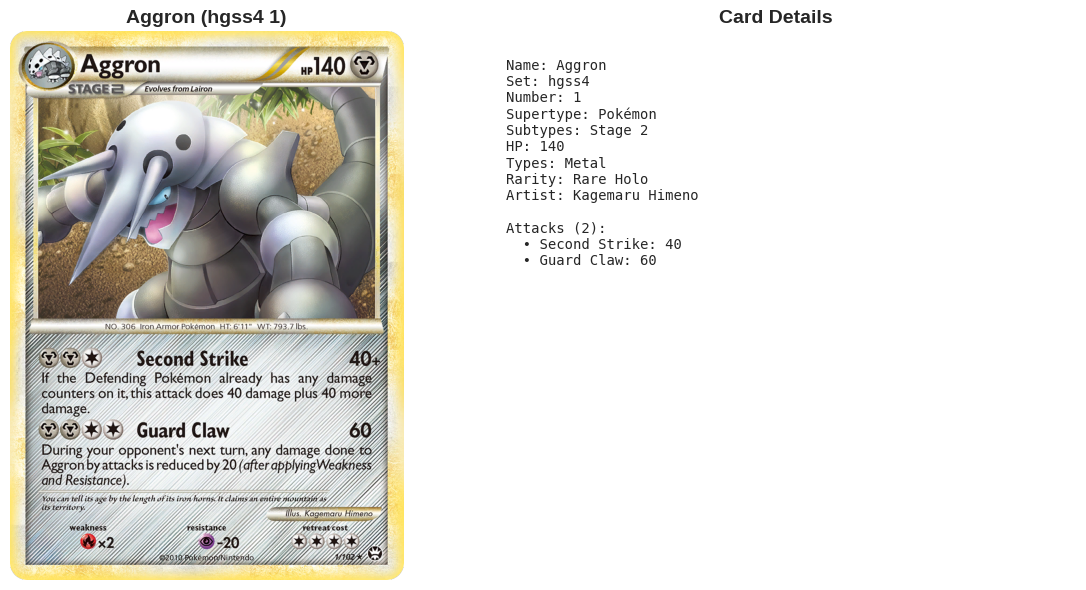

In [29]:
# Display a single card with details
if cards and len(cards) > 0:
    print("Displaying first card with details:")
    display_card(cards[0], show_details=True)
else:
    print("No cards available to display")



Displaying card grid:


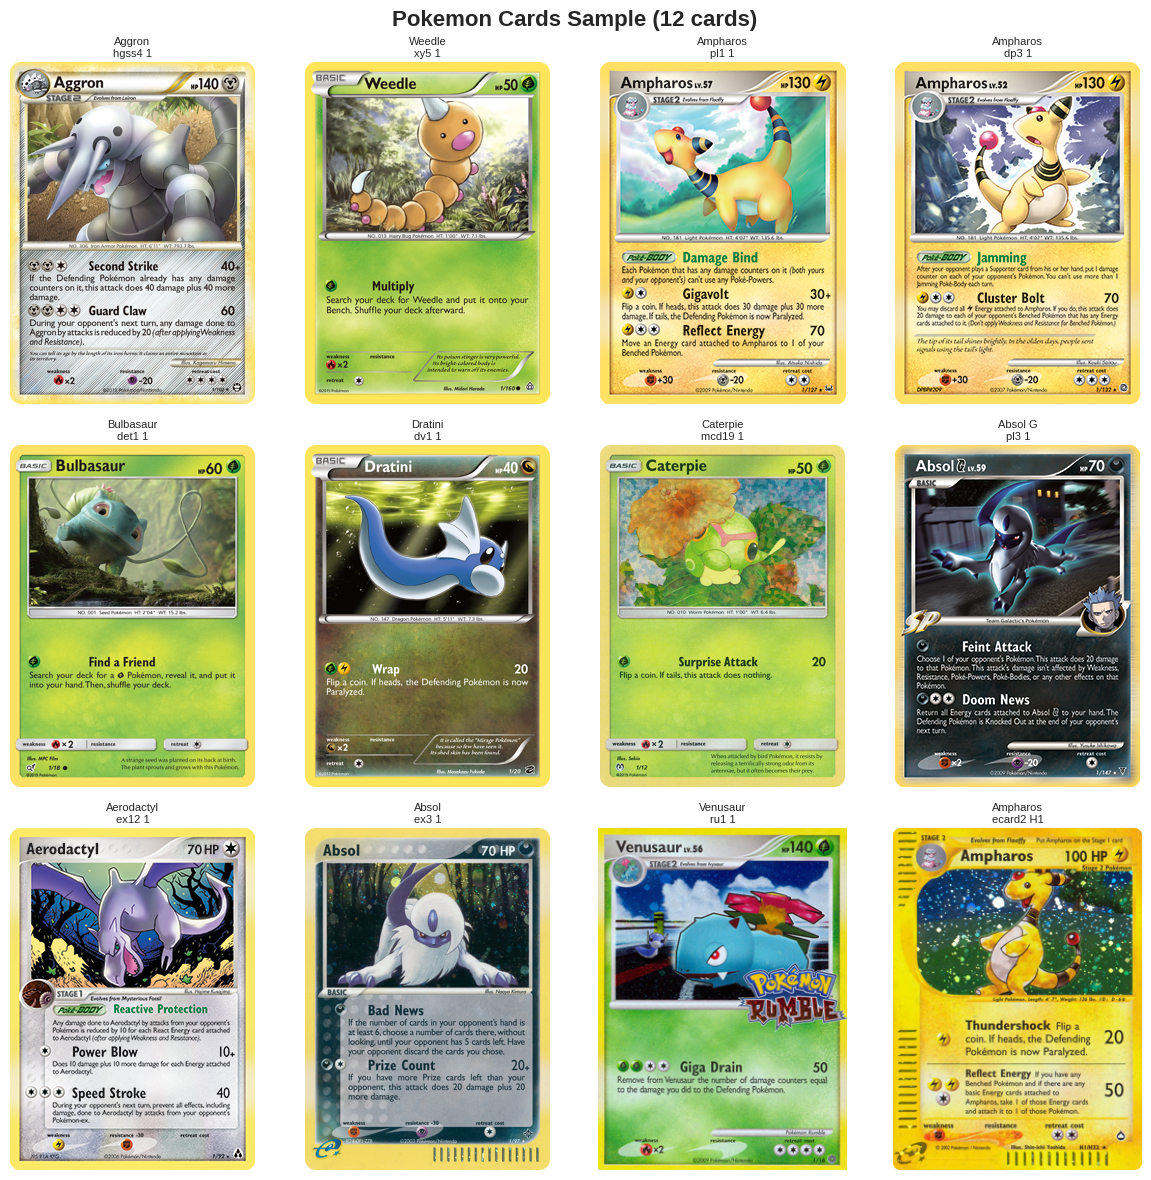

In [30]:
# Display a grid of cards
if cards and len(cards) > 1:
    print("\nDisplaying card grid:")
    display_card_grid(cards, max_cards=12, cols=4)
else:
    print("Not enough cards to display grid")


## Card Statistics

Let's analyze some statistics about the cards in our database.


In [31]:
# Create DataFrame for analysis
if cards:
    card_data = []
    for card in cards:
        card_data.append({
            'name': card.name,
            'set': card.set.id,
            'number': card.number,
            'supertype': card.supertype,
            'rarity': card.rarity,
            'hp': int(card.hp) if card.hp and card.hp.isdigit() else None,
            'types': ', '.join(card.types) if card.types else None,
            'num_attacks': len(card.attacks),
            'has_ability': len(card.abilities) > 0,
            'evolves_from': card.evolves_from is not None
        })
    
    df = pd.DataFrame(card_data)
    
    print("Dataset Overview:")
    print(f"Total cards: {len(df)}")
    print(f"Unique card names: {df['name'].nunique()}")
    print(f"Unique sets: {df['set'].nunique()}")
    
    print("\n" + "="*50)
    print("Data Summary:")
    print(df.info())
else:
    print("No cards available for analysis")


Dataset Overview:
Total cards: 100
Unique card names: 74
Unique sets: 44

Data Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          100 non-null    object
 1   set           100 non-null    object
 2   number        100 non-null    object
 3   supertype     100 non-null    object
 4   rarity        92 non-null     object
 5   hp            100 non-null    int64 
 6   types         100 non-null    object
 7   num_attacks   100 non-null    int64 
 8   has_ability   100 non-null    bool  
 9   evolves_from  100 non-null    bool  
dtypes: bool(2), int64(2), object(6)
memory usage: 6.6+ KB
None


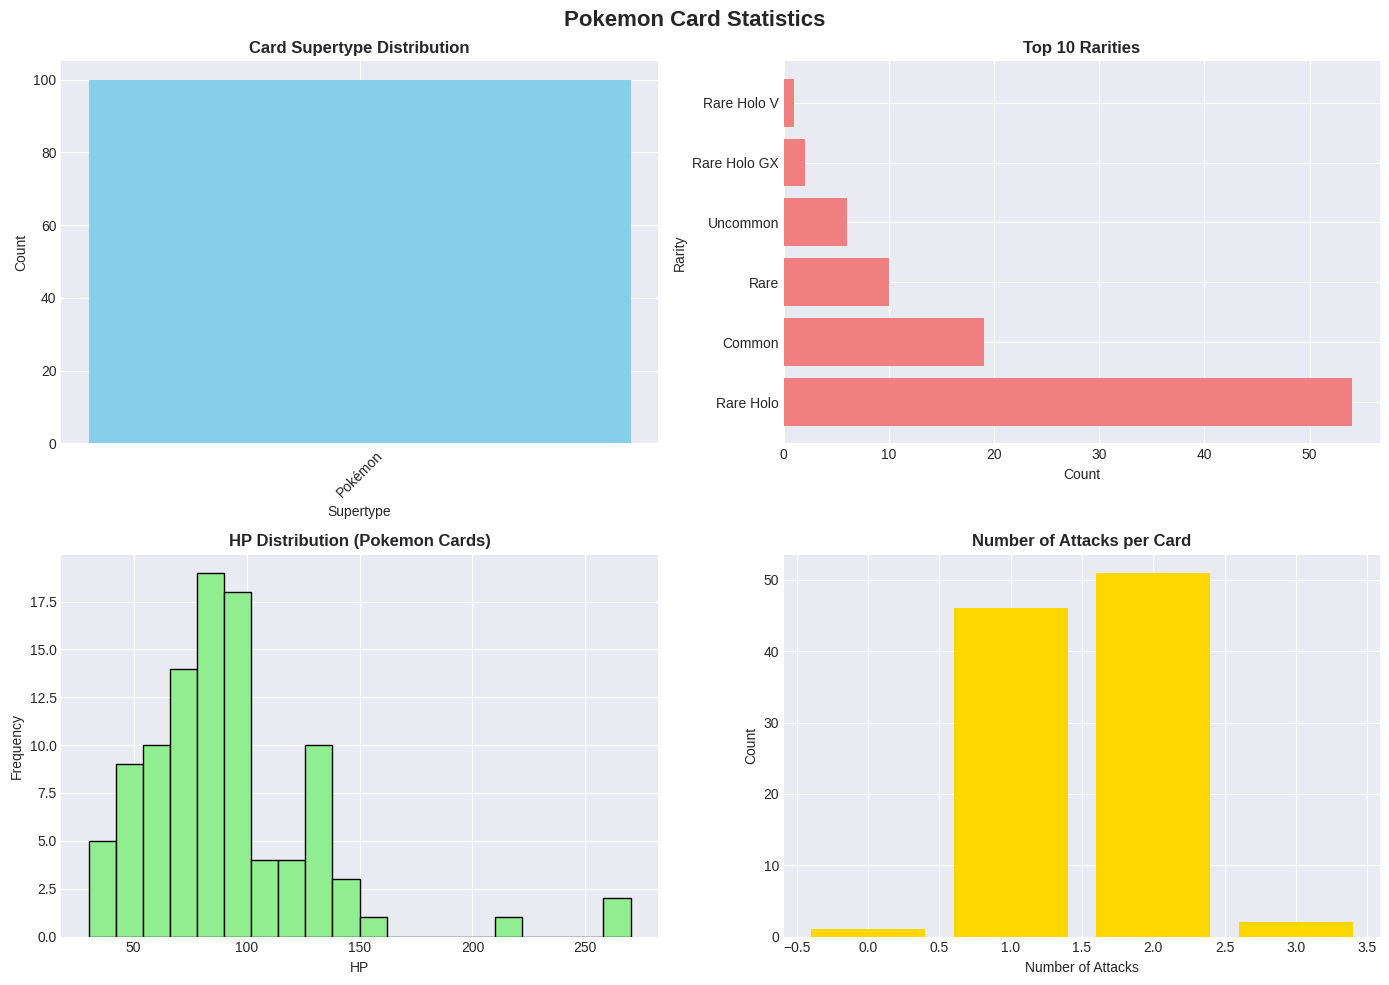

In [32]:
# Visualize distributions
if cards and len(df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # 1. Supertype distribution
    supertype_counts = df['supertype'].value_counts()
    axes[0, 0].bar(supertype_counts.index, supertype_counts.values, color='skyblue')
    axes[0, 0].set_title('Card Supertype Distribution', fontsize=12, fontweight='bold')
    axes[0, 0].set_xlabel('Supertype')
    axes[0, 0].set_ylabel('Count')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 2. Rarity distribution
    rarity_counts = df['rarity'].value_counts().head(10)
    axes[0, 1].barh(rarity_counts.index, rarity_counts.values, color='lightcoral')
    axes[0, 1].set_title('Top 10 Rarities', fontsize=12, fontweight='bold')
    axes[0, 1].set_xlabel('Count')
    axes[0, 1].set_ylabel('Rarity')
    
    # 3. HP distribution (for Pokemon cards)
    hp_data = df[df['hp'].notna()]['hp']
    if len(hp_data) > 0:
        axes[1, 0].hist(hp_data, bins=20, color='lightgreen', edgecolor='black')
        axes[1, 0].set_title('HP Distribution (Pokemon Cards)', fontsize=12, fontweight='bold')
        axes[1, 0].set_xlabel('HP')
        axes[1, 0].set_ylabel('Frequency')
    else:
        axes[1, 0].text(0.5, 0.5, 'No HP data available', ha='center', va='center')
        axes[1, 0].set_title('HP Distribution', fontsize=12, fontweight='bold')
    
    # 4. Number of attacks distribution
    attack_counts = df['num_attacks'].value_counts().sort_index()
    axes[1, 1].bar(attack_counts.index, attack_counts.values, color='gold')
    axes[1, 1].set_title('Number of Attacks per Card', fontsize=12, fontweight='bold')
    axes[1, 1].set_xlabel('Number of Attacks')
    axes[1, 1].set_ylabel('Count')
    
    plt.suptitle('Pokemon Card Statistics', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data for visualization")
